In [17]:

from utils import *
from classification.classifier import *
from main import ImageProcessingPipeline
from postprocessing.notes import *
from segmentation.segmentor import *
from preprocessing.staff import *
from skimage.draw import rectangle
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, classification_report, accuracy_score
from numpy.linalg import norm
from segmentation.staff_line_removal import StaffLineRemoval
import os
import joblib
import traceback
import pickle
import random

In [18]:
image = cv2.imread("../data/input/testcases/test1.PNG", cv2.IMREAD_GRAYSCALE)
pipeline = ImageProcessingPipeline()
results = pipeline.process(image)
binary = results['denoised_image']

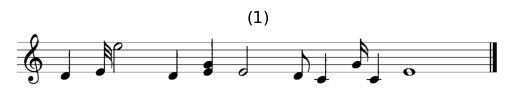

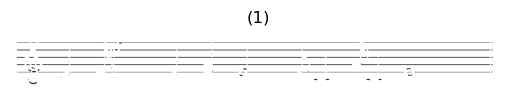

In [19]:
binary = binary//255
show_images([binary])

staffHeight1, spaceHeight1 = getRefLengths(binary)
staffHeight1=2; spaceHeight1=16

filteredImg1, candidates1 = getCandidateStaffs(binary, staffHeight1)
# filteredImg1, candidates1, eliminated1 = removeLonelyStaffs(candidates1, binary, staffHeight1, spaceHeight1, eliminated=[])

show_images([filteredImg1])

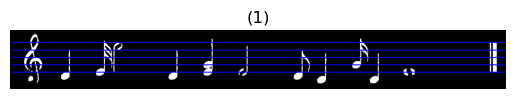

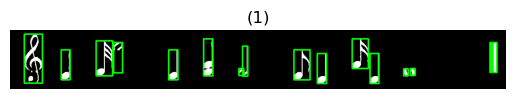

In [21]:
# spacing, staff_row_positions, no_staff_img = StaffLineRemoval.remove_staff_lines_from_image(binary, horizontal=True)
# without_staff = without_staff = (no_staff_img * 255).astype('uint8')
# without_staff = 255-without_staff

without_staff = (binary-filteredImg1).astype(np.uint8)

lines1 = getLines(1-filteredImg1, staffHeight1, spaceHeight1)
staff1 = cv2.cvtColor(without_staff, cv2.COLOR_GRAY2BGR)
for line in lines1:
    cv2.line(staff1,(0,line), (staff1.shape[1]-1, line), (0,0,255), staffHeight1)
show_images([staff1]) 

objects1 = segmentImage(without_staff, lines1, staffHeight1, spaceHeight1)
cropped_objects = []

for o in objects1:
    cropped = without_staff[o[1]:o[3], o[0]:o[2]]
    cropped_objects.append(cropped)
    # show_images([cropped])

cp1 = cv2.cvtColor(without_staff, cv2.COLOR_GRAY2BGR)
for o in objects1:
    cv2.rectangle(cp1, (o[0],o[1]), (o[2],o[3]), (0, 255, 0), 3)
show_images([cp1])

In [22]:
dataset_path = "../data/input/datasets/Dataset2"  # Replace with the correct folder structure

label2id = {
    "a_1": 0, "a_16": 1, "a_2": 2, "a_32": 3, "a_4": 4, "a_8": 5,
    "barline": 6, "chord": 7, "clef": 8, "dot": 9,
    "double_flat": 10, "double_sharp": 11, "flat": 12,
    "natural": 13, "sharp": 14, "t_4_2": 15, "t_4_4": 16
}


id2label = {
    0: "a_1", 1: "a_16", 2: "a_2", 3: "a_32", 4: "a_4", 5: "a_8",
    6: "barline", 7: "chord", 8: "clef", 9: ".", 10: "&&", 11: "##", 12: "&", 13: "", 14: "#", 
    15: r'\meter<"4/2">', 16: r'\meter<"4/4"> '
}

# load the classfier
file = open("./MLP.pickle",'rb')
MLP = pickle.load(file)

# We are going to fix the random seed to make our experiments reproducible 
# since some algorithms use pseudorandom generators
random_seed = 42  
random.seed(random_seed)
np.random.seed(random_seed)

classes = ['a_1', 'a_16', 'a_2', 'a_32', 'a_4', 'a_8', 
           'barline ', 'chord', 'clef', '.', '&&', '##', '&', '', '#', r'\meter<"4/2"> ', r'\meter<"4/4"> ']


def load_dataset(folder_path):
    X = []  # Features
    y = []  # Labels
    total_images = 0
    processed_images = 0

    
    for class_name in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_name)
        if class_name=="b_16" or class_name=="b_32" or class_name=="b_8":
            continue
        if os.path.isdir(class_path):
          
            for file_name in os.listdir(class_path):
                total_images += 1
                file_path = os.path.join(class_path, file_name)
                
                try:
                    # Check file extension and readability
                    if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                        
                        # Skip invalid images
                        if image is None:
                            print(f"Skipping invalid image: {file_path}")
                            continue
                        
                        # Extract descriptors
                        if image.ndim != 2:
                            continue
                        
                        descriptors = extract_hog_features(image,(32,32))
                        
                        # Only add if descriptors are found
                        if descriptors is not None and len(descriptors) > 0:
                            total_images+=1
                            X.append(descriptors)
                            y.append(label2id[class_name])
                            processed_images += 1
                        else:
                            print(f"No descriptors found for: {file_path}")
                
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")

    print(total_images)
    return X, y


import torch.nn.functional as F

X,y=load_dataset(dataset_path)

# Ensure X and y are not empty
if not X or not y:
    raise ValueError("Features (X) and labels (y) cannot be empty.")

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Move tensors to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)


# Predict on the test set
k = 17
y_pred = knn_predict(X_train, y_train, X_test, k)


y_pred_np = y_pred.cpu().numpy()
y_test_np = y_test.cpu().numpy()

# Calculate F1 score
f1 = f1_score(y_test_np, y_pred_np, average='weighted')  # 'weighted' accounts for class imbalance
print(f'F1 Score (weighted): {f1:.2f}')

# Calculate Recall
recall = recall_score(y_test_np, y_pred_np, average='weighted')  # Use 'macro' or 'micro' if needed
print(f'Recall (weighted): {recall:.2f}')

# Print classification report for detailed metrics per class
report = classification_report(y_test_np, y_pred_np, target_names=classes)
print("\nClassification Report:\n")
print(report)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelBinarizer from version 0.24.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MLPClassifier from version 0.24.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


82234
F1 Score (weighted): 0.95
Recall (weighted): 0.95

Classification Report:

                precision    recall  f1-score   support

           a_1       0.98      0.99      0.99       377
          a_16       0.83      0.83      0.83       372
           a_2       0.79      0.95      0.87       486
          a_32       0.73      0.69      0.71       193
           a_4       0.90      0.79      0.84       564
           a_8       0.95      0.92      0.93       438
      barline        0.98      0.97      0.98      1356
         chord       0.93      0.97      0.95       212
          clef       0.99      0.98      0.98       661
             .       0.99      0.97      0.98       891
            &&       0.00      0.00      0.00         4
            ##       0.98      0.95      0.97       175
             &       0.95      0.99      0.97       765
                     0.97      0.99      0.98       704
             #       0.99      0.98      0.99       931
\meter<"4/2">        1

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [23]:
y_pred_MLP = MLP.predict(X_test.cpu().numpy())

# Convert predictions to numpy arrays for metrics calculation
y_pred_np_MLP = y_pred_MLP
y_test_np_MLP = y_test.cpu().numpy()

# Calculate F1 score
f1 = f1_score(y_test_np_MLP, y_pred_np_MLP, average='weighted')
print(f'F1 Score (weighted): {f1:.2f}')

# Calculate Recall
recall = recall_score(y_test_np_MLP, y_pred_np_MLP, average='weighted')
print(f'Recall (weighted): {recall:.2f}')

# Print classification report for detailed metrics per class
report = classification_report(y_test_np_MLP, y_pred_np_MLP, target_names=classes)
print("\nClassification Report:\n")
print(report)

F1 Score (weighted): 0.99
Recall (weighted): 0.99

Classification Report:

                precision    recall  f1-score   support

           a_1       1.00      1.00      1.00       377
          a_16       0.97      0.97      0.97       372
           a_2       0.99      1.00      0.99       486
          a_32       0.95      0.93      0.94       193
           a_4       0.99      0.99      0.99       564
           a_8       1.00      0.99      1.00       438
      barline        1.00      1.00      1.00      1356
         chord       1.00      1.00      1.00       212
          clef       0.99      1.00      1.00       661
             .       1.00      1.00      1.00       891
            &&       0.80      1.00      0.89         4
            ##       1.00      1.00      1.00       175
             &       1.00      0.99      1.00       765
                     0.99      1.00      1.00       704
             #       1.00      0.99      1.00       931
\meter<"4/2">        1.00   

In [24]:
predictions = [predict_image(img, X_train=X_train, y_train=y_train) for img in cropped_objects]

labels = [id2label[pred] for pred in predictions]

id2label2 = {
    0: "a_1", 1: "a_16", 2: "a_2", 3: "a_32", 4: "a_4", 5: "a_8",
    6: "barline", 7: "chord", 8: "clef", 9: "dot",
    10: "double_flat", 11: "double_sharp", 12: "flat",
    13: "natural", 14: "sharp", 15: "t_4_2", 16: "t_4_4"
}

folderClasses = [id2label2[pred] for pred in predictions]

print(folderClasses)

['clef', 'a_4', 'a_16', 'a_2', 'a_4', 'chord', 'a_4', 'a_2', 'a_8', 'a_4', 'a_16', 'a_4', 'a_2', 'dot', 'dot', 'dot']


In [25]:
firstTime = True
output = ""
perviousAccedental = ""
idx = 0
for o in objects1:
    features = extract_hog_features(without_staff[o[1]:o[3], o[0]:o[2]],(32,32))
    # symbol_name = labels[idx]; idx+=1
    symbol_name = classes[np.argmax( MLP.predict_proba([features]))]
    print('symbols:',symbol_name + ', ')

    # show_images([without_staff[o[1]:o[3], o[0]:o[2]]])
    if symbol_name == "a_2" or symbol_name == "a_4":
        if isHalf(without_staff[o[1]:o[3], o[0]:o[2]],spaceHeight1) :
            symbol_name = "a_2"
        else:
            symbol_name = "a_4"
    if symbol_name =="clef":
        if firstTime:
            firstTime = False
            output+= '['
        else:
            output+= '],\n['
    elif firstTime:
    # print('contin')
        continue 
    # beam
    elif (o[2]-o[0]) > 4*spaceHeight1:
        try:
            output += getNoteCharacter(without_staff, o, "beam", lines1, staffHeight1, spaceHeight1)+" "
        except Exception as e:
                print(f"Error occurred: {e}")
        continue
    # dot and barline
    elif symbol_name == "." or symbol_name == "barline ":
            if isDot(without_staff[o[1]:o[3], o[0]:o[2]],spaceHeight1):
                output += "."

    # chord
    elif symbol_name == "chord":
    # print("chord")
        try:
            notes = getchordText([o[1],o[3]],without_staff[o[1]:o[3], o[0]:o[2]],staffHeight1,spaceHeight1,lines1)
        except:
            noteSymbol = getNoteCharacter(without_staff, o, "a_4", lines1, staffHeight1, spaceHeight1)

            output += noteSymbol[0]+perviousAccedental+noteSymbol[1:]+" "
            perviousAccedental = ""

            continue
        output +="{"
        for k in range(0,len(notes)-2,2):
            output += notes[k:k+2]+"/4,"
        output += notes[-2:]+"/4"
        output+= "} "

    # note
    elif symbol_name!="" and  symbol_name[0]=="a" :
        try:
            noteSymbol = getNoteCharacter(without_staff, o, symbol_name, lines1, staffHeight1, spaceHeight1)
            output += noteSymbol[0]+perviousAccedental+noteSymbol[1:]+" "
            perviousAccedental = ""
        except:
#   
            continue
    # accedentals
    elif symbol_name == r'\meter<"4/2"> ' or symbol_name == r'\meter<"4/4"> ':
        output += symbol_name
    else:

        perviousAccedental= symbol_name
output+="]"
if len(output.split("\n"))>1:
    output ="{\n"+output+"\n}"
print(output)


symbols: clef, 
symbols: a_4, 
symbols: a_32, 
symbols: a_2, 
symbols: a_4, 
symbols: chord, 
symbols: a_4, 
symbols: a_4, 
symbols: a_8, 
symbols: a_4, 
symbols: a_16, 
symbols: a_4, 
symbols: ., 
symbols: a_8, 
symbols: ., 
symbols: ., 
[d/4 e/32 e2/2 d/4 {eg/4} e/2 d/2 d/8 c/4 g/16 c/4 e/8 ]
